In [1]:
from datasets import load_dataset, Audio
from transformers import SpeechT5Processor
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import soundfile as sf
import io
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch
from transformers import SpeechT5Processor
from transformers import SpeechT5ForTextToSpeech
from functools import partial
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
import os
from speechbrain.inference.speaker import EncoderClassifier
from transformers import SpeechT5HifiGan


In [2]:
dataset = load_dataset(
    "openslr/librispeech_asr",
    "clean",
    split="train.100[:3000]",   # only download 3k examples
)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000, decode = False))
dataset[0]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

{'file': '/home/albert/.cache/huggingface/datasets/downloads/extracted/bc0d9a6ef85c2d487c9c6efbc91f8892df927c69d3f80545a668cc058d5f677e/374-180298-0000.flac',
 'audio': {'bytes': b'fLaC\x00\x00\x00"\x10\x00\x10\x00\x00\x04\xa4\x00\x16\xc5\x03\xe8\x00\xf0\x00\x03\x8c \xbc\x9b)\\H\xbe6\xbe\xc0\xad\xc8H\x9a\xa8N^\x03\x00\x00$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x00\x00\x00\x00\x00\x02p\x00\x00\x00\x00\x00\x00\x02j\xeb\x10\x00\x04\x00\x00( \x00\x00\x00reference libFLAC 1.2.1 20070917\x00\x00\x00\x00\x81\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [3]:
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
tokenizer = processor.tokenizer

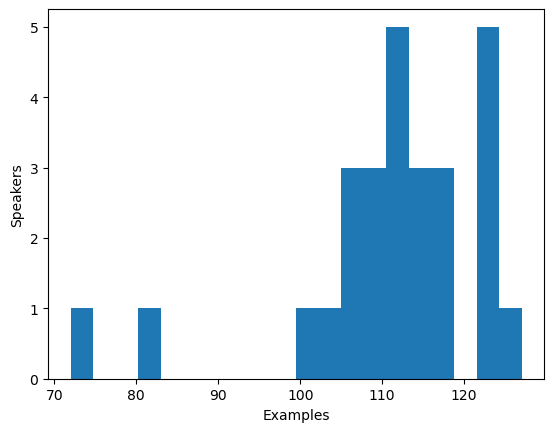

In [4]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [5]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 150


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

In [6]:
len(set(dataset["speaker_id"]))

25

In [7]:
len(dataset)

2847

In [8]:
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=None
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

c:\Users\sidpk\anaconda3\envs\tts-finetune-hf\Lib\site-packages\speechbrain\utils\autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)
c:\Users\sidpk\anaconda3\envs\tts-finetune-hf\Lib\inspect.py:1004: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
c:\Users\sidpk\anaconda3\envs\tts-finetune-hf\Lib\site-packages\speechbrain\utils\checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code d

In [9]:
def prepare_dataset(example):
    speaker_id = example["speaker_id"]

    with io.BytesIO(example["audio"]["bytes"]) as f:
        audio_array, sr = sf.read(f)

    example = processor(
        text = example["text"],
        sampling_rate = sr,
        audio_target = audio_array,
        return_attention_mask = False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    #keeping speaker id
    example["speaker_id"] = speaker_id

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio_array)

    return example

In [10]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_id', 'speaker_embeddings']

In [11]:
processed_example["speaker_embeddings"].shape

(512,)

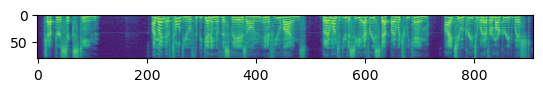

In [12]:
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [13]:
dataset = dataset.map(prepare_dataset, remove_columns= dataset.column_names)

Map:   0%|          | 0/2847 [00:00<?, ? examples/s]

In [14]:
dataset = dataset.train_test_split(test_size=0.1)

In [15]:
len(dataset["train"])

2562

In [16]:
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [17]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

In [18]:
print(torch.__version__)

2.5.1


In [19]:
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint, use_safetensors=True)

In [20]:
# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [21]:
training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    warmup_steps=100,
    num_train_epochs=8,
    gradient_checkpointing=False,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",         
    logging_strategy="epoch",      
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"]
)

In [22]:
trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

C:\Users\sidpk\AppData\Local\Temp\ipykernel_5804\2641489269.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.512900,0.412650
2,0.440200,0.386788
3,0.421700,0.379631
4,0.414500,0.382601
5,0.407900,0.375387
6,0.406200,0.373678
7,0.398200,0.369969
8,0.399300,0.370149


c:\Users\sidpk\anaconda3\envs\tts-finetune-hf\Lib\site-packages\transformers\modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=648, training_loss=0.4251222610473633, metrics={'train_runtime': 1609.2346, 'train_samples_per_second': 12.736, 'train_steps_per_second': 0.403, 'total_flos': 4266990388123056.0, 'train_loss': 0.4251222610473633, 'epoch': 8.0})

In [24]:
example = dataset["test"][0]
print(example.keys())
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0).to(device = "cuda")

dict_keys(['speaker_id', 'input_ids', 'labels', 'speaker_embeddings'])


In [25]:
text = "THIS IS A DEEP LEARNING CLASS WHERE I AM HOPING THIS PROJECT GOES WELL I AM DOING THIS PROJECT THIS CODE IS DERIVED FROM HUGGING FACE ITS DUE THIS SUNDAY LIMITED TIME LEFT"

In [26]:
inputs = processor(text=text, return_tensors="pt").to("cuda")

In [27]:
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan", use_safetensors=True).to(device = "cuda")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [28]:
speech.cpu().device

device(type='cpu')

In [29]:
#This is generated after fine tuning
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [30]:
labels_tensor = torch.tensor(example["labels"])
labels_tensor = labels_tensor.unsqueeze(0).to("cuda")
orignal_speech = vocoder(labels_tensor)
Audio(orignal_speech.detach().cpu().numpy(), rate=16000)